In [1]:
import torch
torch.multiprocessing.set_start_method("spawn")        # https://github.com/pytorch/pytorch/issues/3491#event-1326332533
import torch.nn as nn
import torch.optim
from torchvision import datasets,transforms

import numpy as np
import matplotlib
matplotlib.use('Agg')
get_ipython().magic('matplotlib inline')
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplot
from sklearn.metrics import accuracy_score

In [2]:
img_channels = 1
if img_channels==3:
    transformImg = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
else:
    transformImg = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize([0.5], [0.5])])
train = datasets.MNIST(root='../data', train=True, download=True, transform=transformImg)
valid = datasets.MNIST(root='../data', train=True, download=True, transform=transformImg)
test = datasets.MNIST(root='../data', train=False, download=True, transform=transformImg)

In [3]:
# create training and validation set indexes (80-20 split)
idx = list(range(len(train)))
np.random.seed(1009)
np.random.shuffle(idx)          
train_idx = idx[ : int(0.8 * len(idx))]       
valid_idx = idx[int(0.8 * len(idx)) : ]

(<matplotlib.axes._subplots.AxesSubplot at 0x7f61bd143908>,
 <matplotlib.image.AxesImage at 0x7f61bd11d630>)

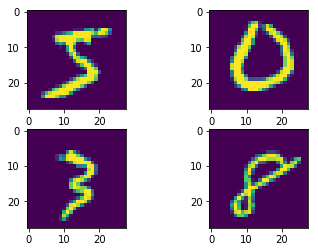

In [4]:
# sample images
fig1 = train.data[0].numpy()  
fig2 = train.data[2500].numpy()
fig3 = train.data[25000].numpy()  
fig4 = train.data[59999].numpy()
subplot(2,2,1), plt.imshow(fig1)  
subplot(2,2,2), plt.imshow(fig2) 
subplot(2,2,3), plt.imshow(fig3)
subplot(2,2,4), plt.imshow(fig4)

In [5]:
# generate training and validation set samples
train_set = torch.utils.data.sampler.SubsetRandomSampler(train_idx)    
valid_set = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)  

# Load training and validation data based on above samples
# Size of an individual batch during training and validation is 30
# Both training and validation datasets are shuffled at every epoch by 'SubsetRandomSampler()'. Test set is not shuffled.
train_loader = torch.utils.data.DataLoader(train, batch_size=30, sampler=train_set, num_workers=4)  
valid_loader = torch.utils.data.DataLoader(train, batch_size=30, sampler=valid_set, num_workers=4)    
test_loader = torch.utils.data.DataLoader(test, num_workers=4)

In [6]:
for batch_num, training_batch in enumerate(train_loader):
    # split training data into inputs and labels
    inputs, labels = training_batch                              # 'training_batch' is a list
    break

torch.Size([30, 1, 28, 28]) torch.Size([30])


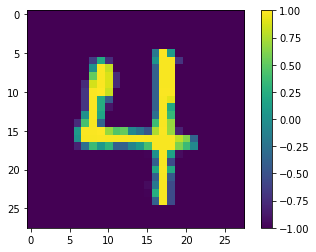

In [7]:
print(inputs.shape,labels.shape)
plt.imshow(inputs[0].squeeze().numpy())
plt.colorbar()

In [21]:
# Defining the network (LeNet-5)  
class LeNet5(torch.nn.Module):    
     
    def __init__(self,img_channels=1):
        super(LeNet5, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) 
        # Fully connected layer
        self.fc1 = nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = nn.Linear(84, 10)        # convert matrix with 84 features to a matrix of 10 features (columns)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxpool1(x) 
        x = torch.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.maxpool2(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x = torch.relu(self.fc1(x.view(-1, 16*5*5)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def forward_allout(self, x):
        x1 = torch.relu(self.conv1(x))
        x1 = self.maxpool1(x1)        # max-pooling with 2x2 grid
        x2 = torch.relu(self.conv2(x1))
        x2 = self.maxpool2(x2)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x3 = torch.relu(self.fc1(x2.view(-1, 16*5*5)))
        x4 = torch.relu(self.fc2(x3))
        x5 = self.fc3(x4)
        return x1,x2,x3,x4,x5

# Defining the network (VGG-11, reduced)  
class VGG(torch.nn.Module):          
     
    def __init__(self,img_channels=1):
        super(VGG, self).__init__()
        # Convolution (In VGG, 224x244 images are given as input, but here we use 32x32. Hence padding of 2 is done below)
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxpool1(x)        # max-pooling with 2x2 grid
        x = torch.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.maxpool3(x)
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = self.maxpool3(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x = torch.relu(self.fc1(x.view(-1, 512)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def forward_allout(self, x):
        x1 = torch.relu(self.conv1(x))
        x1 = self.maxpool1(x1)        # max-pooling with 2x2 grid
        x2 = torch.relu(self.conv2(x1))
        x2 = self.maxpool2(x2)
        x3 = torch.relu(self.conv3(x2))
        x4 = torch.relu(self.conv4(x3))
        x4 = self.maxpool3(x4)
        x5 = torch.relu(self.conv5(x4))
        x6 = torch.reluReLU(self.conv6(x5))
        x6 = self.maxpool3(x6)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x7 = torch.relu(self.fc1(x6.view(-1, 512)))
        x8 = torch.relu(self.fc2(x7))
        x9 = self.fc3(x8)
        return x1,x2,x3,x4,x5,x6,x7,x8,x9
     
# net = LeNet5(img_channels=img_channels)
net = VGG(img_channels=img_channels)
net.cuda()

VGG(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_feat

In [22]:
# set up loss function -- 'SVM Loss' a.k.a 'Cross-Entropy Loss'
loss_func = torch.nn.CrossEntropyLoss()
       
# SGD used for optimization, momentum update used as parameter update  
optimization = torch.optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Let training begin!
numEpochs = 20    
training_accuracy = []     
validation_accuracy = []

for epoch in range(numEpochs):
    
    # training set -- perform model training
    epoch_training_loss = 0.0
    num_batches = 0
    for batch_num, training_batch in enumerate(train_loader):        # 'enumerate' is a super helpful function        
        # split training data into inputs and labels
        inputs, labels = training_batch                              # 'training_batch' is a list
        inputs, labels = inputs.to(device), labels.to(device)
        # Make gradients zero for parameters 'W', 'b'
        net.zero_grad()         
        # forward, backward pass with parameter update
        forward_output = net(inputs)
        loss = loss_func(forward_output, labels)
        loss.backward()   
        optimization.step()
        # calculating loss 
        epoch_training_loss += loss.item()
        num_batches += 1
        
    print("epoch: ", epoch, ", loss: ", epoch_training_loss/num_batches)            
     
    # calculate training set accuracy
    accuracy = 0.0 
    num_batches = 0
    for batch_num, training_batch in enumerate(train_loader):        # 'enumerate' is a super helpful function        
        num_batches += 1
        inputs, actual_val = training_batch
        # perform classification
        predicted_val = net(inputs.cuda())
        # convert 'predicted_val' tensor to numpy array and use 'numpy.argmax()' function    
        predicted_val = predicted_val.cpu().data.numpy()    # convert cuda() type to cpu(), then convert it to numpy
        predicted_val = np.argmax(predicted_val, axis = 1)  # retrieved max_values along every row    
        # accuracy   
        accuracy += accuracy_score(actual_val.numpy(), predicted_val)
    training_accuracy.append(accuracy/num_batches)   

    # calculate validation set accuracy 
    accuracy = 0.0 
    num_batches = 0
    for batch_num, validation_batch in enumerate(valid_loader):        # 'enumerate' is a super helpful function        
        num_batches += 1
        inputs, actual_val = validation_batch
        # perform classification
        predicted_val = net(inputs.cuda())
        # convert 'predicted_val' tensor to numpy array and use 'numpy.argmax()' function    
        predicted_val = predicted_val.cpu().data.numpy()    # convert cuda() type to cpu(), then convert it to numpy
        predicted_val = np.argmax(predicted_val, axis = 1)  # retrieved max_values along every row    
        # accuracy        
        accuracy += accuracy_score(actual_val.numpy(), predicted_val)
    validation_accuracy.append(accuracy/num_batches)

epoch:  0 , loss:  2.3013104087114336
epoch:  1 , loss:  2.2996611052751543
epoch:  2 , loss:  2.244742033705115
epoch:  3 , loss:  0.5718770738085732
epoch:  4 , loss:  0.15258235347573645
epoch:  5 , loss:  0.09669577383814612
epoch:  6 , loss:  0.07435378480382497


In [11]:
loss.item()

0.04163114354014397

In [17]:
predicted_val = net(inputs.cuda()).cpu().data.numpy()
print(predicted_val)
predicted_val = np.argmax(predicted_val, axis = 1)
predicted_val

[[-7.77920341e+00 -2.92547727e+00 -3.72444466e-02  2.00230675e+01
  -6.63945007e+00  3.51048183e+00 -1.30993729e+01 -4.57993937e+00
   6.60837841e+00  4.89036179e+00]
 [-1.04953995e+01  1.76401854e+00 -3.90894747e+00  1.57816162e+01
  -4.58030891e+00  2.64143467e+00 -1.19387808e+01  6.00518405e-01
   4.10179520e+00  4.39077473e+00]
 [ 2.51964688e+00 -7.65917826e+00  1.57468586e+01  3.41287303e+00
   2.62598172e-02 -3.36821556e+00 -7.48287725e+00  2.55575728e+00
  -5.79438269e-01  1.11174548e+00]
 [ 1.82764416e+01 -7.87661314e+00  3.80657601e+00 -7.47767591e+00
   3.36434841e-02 -2.75095797e+00  7.19423831e-01 -4.92555237e+00
   1.45271277e+00  6.93182051e-01]
 [-4.99670649e+00  3.93137264e+00  1.87157750e+00  4.74343157e+00
  -2.71842790e+00 -5.20827723e+00 -1.73344097e+01  1.48895655e+01
   4.45397806e+00  4.32998705e+00]
 [-1.33355865e+01 -3.99399543e+00 -1.84036589e+00  2.64473228e+01
  -6.92456818e+00  4.83846283e+00 -2.02282391e+01 -2.90113187e+00
   8.01888084e+00  1.04762716e+01

array([3, 3, 2, 0, 7, 3, 6, 8, 0, 1, 2, 9, 9, 3, 5, 6, 0, 3, 3, 7, 1, 9,
       7, 5, 0, 4, 0, 9, 1, 7])

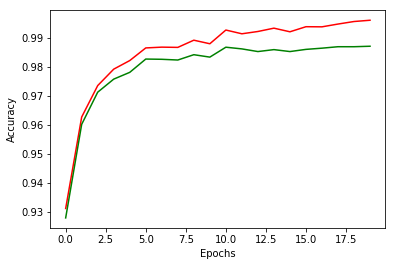

In [18]:
epochs = list(range(numEpochs))

# plotting training and validation accuracies
fig1 = plt.figure()
plt.plot(epochs, training_accuracy, 'r')
plt.plot(epochs, validation_accuracy, 'g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy") 
plt.show(fig1)

In [33]:
# test the model on test dataset
correct = 0
total = 0
for test_data in test_loader:
    total += 1
    inputs, actual_val = test_data 
    # perform classification
    predicted_val = net.forward_allout(inputs.cuda())
    # convert 'predicted_val' GPU tensor to CPU tensor and extract the column with max_score
    predicted_val = predicted_val[-1].cpu().data
    max_score, idx = torch.max(predicted_val, 1)
    # compare it with actual value and estimate accuracy
    correct += (idx == actual_val).sum()
       
print("Classifier Accuracy: ", correct.numpy()/total * 100)

Classifier Accuracy:  98.74000000000001


(<matplotlib.axes._subplots.AxesSubplot at 0x7f9729201dd8>,
 <matplotlib.image.AxesImage at 0x7f9728fad8d0>)

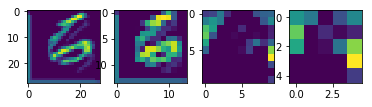

In [30]:
conv1 = torch.relu(net.conv1(inputs.cuda()))
maxpool1 = net.maxpool1(conv1)
conv2 = torch.relu(net.conv2(maxpool1))
maxpool2 = net.maxpool2(conv2)

subplot(1,4,1), plt.imshow(conv1[0,0,:,:].squeeze().detach().cpu().numpy())
subplot(1,4,2), plt.imshow(maxpool1[0,0,:,:].squeeze().detach().cpu().numpy())
subplot(1,4,3), plt.imshow(conv2[0,0,:,:].squeeze().detach().cpu().numpy())
subplot(1,4,4), plt.imshow(maxpool2[0,0,:,:].squeeze().detach().cpu().numpy())

In [34]:
# testout = net.forward_allout(test.data[0].cuda().view(1,1,28,28))
testout = net.forward_allout(inputs.cuda())
# x1.shape,x2.shape,x3.shape,x4.shape,x5.shape

In [35]:
test.data.view(-1,1,28,28).cuda().size()

torch.Size([10000, 1, 28, 28])

In [36]:
testout = net.forward_allout(test.data.view(-1,1,28,28).to(device=device, dtype=torch.float))

In [37]:
testout[0].size()

torch.Size([10000, 6, 14, 14])

(tensor([ 909.3293, -311.1581, -416.9189, -563.4032,  471.1881, -131.3940,
         2160.8147, -837.3452,  270.8433, -550.9911], device='cuda:0',
        grad_fn=<SelectBackward>), 6)

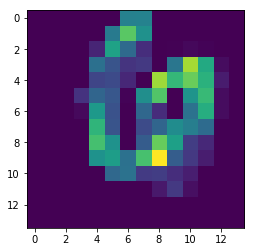

In [39]:
inum=66
plt.imshow(testout[0][inum,0,:,:].squeeze().detach().cpu().numpy())
testout[-1][inum],np.argmax(testout[-1][inum].detach().cpu().numpy())

In [40]:
import scipy.io

scipy.io.savemat('mnist_LeNet5.mat',{'x1':testout[0].detach().cpu().numpy(),\
                                     'x2':testout[1].detach().cpu().numpy(),\
                                     'x3':testout[2].detach().cpu().numpy(),\
                                     'x4':testout[3].detach().cpu().numpy(),\
                                     'x5':testout[4].detach().cpu().numpy(),\
                                     'labels':test.targets.detach().cpu().numpy()})